In [26]:
import lib ## my module set

import os
import torch
import torchvision
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import random

import seaborn as sns


from tqdm import tqdm
from IPython.display import display
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pytorch_metric_learning import losses
from pytorch_metric_learning import miners
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0, mobilenet_v2, efficientnet_b1, efficientnet_b2
from sklearn.metrics import silhouette_score, silhouette_samples


%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


plt.rcParams['font.family'] = 'Liberation Serif'

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # 멀티 GPU를 사용하는 경우
np.random.seed(42)
random.seed(42)
# torch.backends.cudnn.deterministic = True ## 속도가 느려질 수 있음
# torch.backends.cudnn.benchmark = False

In [27]:
train = pd.read_csv("./train_v2.csv")
valid = pd.read_csv("./valid_v2.csv")
test = pd.read_csv("./test_v2.csv")

In [35]:
train_dataset = lib.CustomDataset(train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

valid_dataset = lib.CustomDataset(valid, train_test= False)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

test_dataset = lib.CustomDataset(test, train_test = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory= True, num_workers = 8)

In [36]:
#mobi = mobilenet_v2(weights = 'IMAGENET1K_V1')

In [37]:
Efficient_b0 = efficientnet_b2(weights = 'IMAGENET1K_V1')
Efficient_b0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [40]:
Efficient_b0 = efficientnet_b2(weights = 'IMAGENET1K_V1')
Efficient_b0 = lib.freeze_layers_by_percentage(Efficient_b0, 0.0)

Efficient_b0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace = True),
    nn.Linear(1408, 256, bias = True))

Efficient_b0 = Efficient_b0.to(device)

Features 블록 총 9개 중 0개 고정
고정할 블록들: []
훈련가능: features.0.0.weight
훈련가능: features.0.1.weight
훈련가능: features.0.1.bias
훈련가능: features.1.0.block.0.0.weight
훈련가능: features.1.0.block.0.1.weight
훈련가능: features.1.0.block.0.1.bias
훈련가능: features.1.0.block.1.fc1.weight
훈련가능: features.1.0.block.1.fc1.bias
훈련가능: features.1.0.block.1.fc2.weight
훈련가능: features.1.0.block.1.fc2.bias
훈련가능: features.1.0.block.2.0.weight
훈련가능: features.1.0.block.2.1.weight
훈련가능: features.1.0.block.2.1.bias
훈련가능: features.1.1.block.0.0.weight
훈련가능: features.1.1.block.0.1.weight
훈련가능: features.1.1.block.0.1.bias
훈련가능: features.1.1.block.1.fc1.weight
훈련가능: features.1.1.block.1.fc1.bias
훈련가능: features.1.1.block.1.fc2.weight
훈련가능: features.1.1.block.1.fc2.bias
훈련가능: features.1.1.block.2.0.weight
훈련가능: features.1.1.block.2.1.weight
훈련가능: features.1.1.block.2.1.bias
훈련가능: features.2.0.block.0.0.weight
훈련가능: features.2.0.block.0.1.weight
훈련가능: features.2.0.block.0.1.bias
훈련가능: features.2.0.block.1.0.weight
훈련가능: features.2.0.block.

In [41]:
## 학습을 위한 최적화, 함수, Miner 설정

loss_fn = losses.GeneralizedLiftedStructureLoss(neg_margin=1, pos_margin=0)
optimizer = torch.optim.AdamW(Efficient_b0.parameters(), lr=1e-4)
miner_func = miners.MultiSimilarityMiner(epsilon=0.001)

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0

f = open("./EfficientNetb0.txt",'w')
f.close()

for epoch in range(Epochs):
    with open("./EfficientNetb0.txt", "a") as f:
        train_loss = lib.metric_train(train_loader, Efficient_b0, loss_fn, optimizer, miner_func)
        valid_loss = lib.metric_validation(valid_loader, Efficient_b0, loss_fn, miner_func)
        f.write(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f} \n")
        print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f}")
        
        if best_loss > valid_loss:
            best_loss = valid_loss
            patience = 0
            print(f'Epoch {epoch} Model saved ')
            torch.save({
                    'model' : Efficient_b0.state_dict(),
                    'optimizer' : optimizer.state_dict()}, '../model_weight/Deep_metric/Efficientb0_None_pretrained.pth')
        else:
            patience += 1
            if patience == 10:
                print('early stopping')
                break
            


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch 0 : Train Loss = 5.1785, Valid Loss = 3.3603
Epoch 0 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch 1 : Train Loss = 3.7429, Valid Loss = 3.2559
Epoch 1 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.58it/s]


Epoch 2 : Train Loss = 3.2398, Valid Loss = 3.0269
Epoch 2 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 3 : Train Loss = 3.1904, Valid Loss = 2.9371
Epoch 3 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.75it/s]


Epoch 4 : Train Loss = 3.1836, Valid Loss = 2.9604


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.61it/s]


Epoch 5 : Train Loss = 2.9137, Valid Loss = 2.8432
Epoch 5 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 6 : Train Loss = 2.8164, Valid Loss = 2.6792
Epoch 6 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch 7 : Train Loss = 2.7199, Valid Loss = 2.3732
Epoch 7 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.52it/s]


Epoch 8 : Train Loss = 2.5519, Valid Loss = 2.5880


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.62it/s]


Epoch 9 : Train Loss = 2.4576, Valid Loss = 2.3791


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.58it/s]


Epoch 10 : Train Loss = 2.3174, Valid Loss = 2.1631
Epoch 10 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 11 : Train Loss = 2.0997, Valid Loss = 2.4086


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.65it/s]


Epoch 12 : Train Loss = 2.0582, Valid Loss = 2.3539


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.69it/s]


Epoch 13 : Train Loss = 1.9725, Valid Loss = 2.1825


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.47it/s]


Epoch 14 : Train Loss = 1.8611, Valid Loss = 2.1253
Epoch 14 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.43it/s]


Epoch 15 : Train Loss = 1.7246, Valid Loss = 1.8965
Epoch 15 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch 16 : Train Loss = 1.4642, Valid Loss = 1.9105


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.00it/s]


Epoch 17 : Train Loss = 1.2991, Valid Loss = 1.8966


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.67it/s]


Epoch 18 : Train Loss = 1.2696, Valid Loss = 1.6936
Epoch 18 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.75it/s]


Epoch 19 : Train Loss = 1.0129, Valid Loss = 1.6972


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.65it/s]


Epoch 20 : Train Loss = 1.1042, Valid Loss = 2.1127


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 21 : Train Loss = 1.2125, Valid Loss = 1.8897


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.56it/s]


Epoch 22 : Train Loss = 1.1818, Valid Loss = 1.7754


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch 23 : Train Loss = 0.9629, Valid Loss = 1.8001


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.57it/s]


Epoch 24 : Train Loss = 0.7648, Valid Loss = 1.7762


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 25 : Train Loss = 0.6603, Valid Loss = 1.7204


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch 26 : Train Loss = 0.7364, Valid Loss = 2.0639


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 27 : Train Loss = 0.7805, Valid Loss = 1.8589


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.66it/s]

Epoch 28 : Train Loss = 0.8038, Valid Loss = 2.0903
early stopping


## Deep Metric Model Load 및 시각화

In [44]:
Efficient_b0 = efficientnet_b2(weights = 'IMAGENET1K_V1')
# Efficient_b0.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace = True),
#     nn.Linear(in_features = 1280, out_features = 256, bias = True),)
Efficient_b0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace = True),
    nn.Linear(1408, 256, bias = True))

checkpoint = torch.load('../model_weight/Deep_metric/Efficientb0_None_pretrained.pth')

Efficient_b0.load_state_dict(checkpoint['model'])
Efficient_b0 = Efficient_b0.to(device)


In [45]:
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)


In [51]:
embeddings = []
labels = []

with torch.no_grad():
    Efficient_b0.eval()
    for data, label in tqdm(total_loader_t):
        embedding = Efficient_b0(data.to(device))
        embeddings.append(embedding) ## embeddings = (n, emb)
        labels.append(label.item())

embeddings = torch.stack(embeddings, dim = 1).squeeze()



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:02<00:00, 57.21it/s]


0.4284866452217102

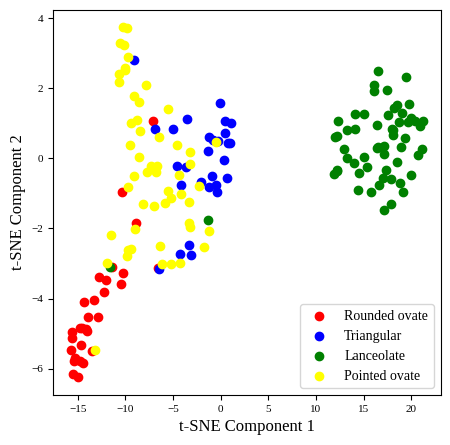

In [52]:

plt.figure(figsize=(5, 5))

plt.rc('xtick', labelsize=8)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=8)  # y축 눈금 폰트 크기
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10) 

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings.detach().cpu())

df_tsne = pd.DataFrame(data = X_tsne)
df_tsne['label']= labels
df_tsne

plt.scatter(df_tsne[df_tsne['label'] == 0][0], df_tsne[df_tsne['label'] == 0][1], label = 'Rounded ovate',  c= 'red')
plt.scatter(df_tsne[df_tsne['label'] == 1][0], df_tsne[df_tsne['label'] == 1][1], label = 'Triangular', c= 'blue')
plt.scatter(df_tsne[df_tsne['label'] == 2][0], df_tsne[df_tsne['label'] == 2][1], label = 'Lanceolate', c= 'green')
plt.scatter(df_tsne[df_tsne['label'] == 3][0], df_tsne[df_tsne['label'] == 3][1], label = 'Pointed ovate',  c= 'yellow')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.savefig('./result_images/Efficient_tsne_validation.png')

score = silhouette_score(X_tsne, labels)
score

In [50]:
score_samples = silhouette_samples(df_tsne[[0, 1]], df_tsne['label'])
df_tsne['sil_coeffi'] = score_samples
df_tsne.groupby('label')['sil_coeffi'].mean()

label
0    0.590899
1    0.556500
2    0.760546
3    0.251654
Name: sil_coeffi, dtype: float32

## 2-stage Classifier 학습

In [53]:
## 2-stage Classifier Training

class MyNeural(nn.Module):
    def __init__(self, model):
        super(MyNeural, self).__init__()

        self.mother = model

        for param in self.mother.parameters():
            param.requires_grad = False    
        
        self.classifier = nn.Sequential(
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = True),
            nn.Linear(256, 64, bias = True),
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = True),
            nn.Linear(64, 4, bias = True)
        )

    def forward(self, x):
        embedding = self.mother(x)
         
        x = self.classifier(embedding)

        return embedding, x



In [ ]:
Efficient_with_classifier = MyNeural(Efficient_b0).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(Efficient_with_classifier.parameters(), lr=1e-4)

save_model_name = 'Efficientb2_with_classifier'

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0

f = open(f"./loss_log/{save_model_name}.txt",'w')
f.close()


for epoch in range(Epochs):
    with open(f"./loss_log/{save_model_name}.txt",'a') as f:
        train_loss, train_correct = lib.classifier_train(train_loader, Efficient_with_classifier, loss_fn, optimizer)
        valid_loss, valid_correct = lib.classifier_validation(valid_loader, Efficient_with_classifier, loss_fn)

        f.write(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct} \n")
        print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct}")
        
        if best_loss > valid_loss:
            best_loss = valid_loss
            patience = 0
            print(f'Epoch {epoch} Model saved ')
            torch.save({
                    'model' : Efficient_with_classifier.state_dict(),
                    'optimizer' : optimizer.state_dict()}, f'../model_weight/Deep_metric/{save_model_name}.pth')
        else:
            patience += 1
            if patience == 10:
                print('early stopping')
                break
        

Valid:  55%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 6/11 [00:02<00:01,  3.23it/s]

In [ ]:
Efficient_with_classifier = MyNeural(Efficient_b0).to(device)

checkpoint = torch.load('../model_weight/Deep_metric/Efficientb0_with_classifier.pth')

Efficient_with_classifier.load_state_dict(checkpoint['model'])

valid_loss, valid_correct = lib.classifier_validation(total_loader_v, Efficient_with_classifier, loss_fn)
print(valid_correct)

In [ ]:
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)

pred_acc = []
real_acc = []
embeddings = []


with torch.no_grad():
    Efficient_with_classifier.eval()
    for data, label in tqdm(total_loader_t):
    
        embedding, pred = Efficient_with_classifier(data.to(device)) ## embeddings = (n, emb)
        embeddings.append(embedding)
        
        pred_acc.append(pred.argmax(1).item())
        real_acc.append(label.item())

embeddings = torch.stack(embeddings, dim = 1).squeeze()


In [ ]:
plt.rc('xtick', labelsize=11)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=11) 

cm = confusion_matrix(real_acc, pred_acc, normalize = 'true')
cm = pd.DataFrame(cm , columns = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'],index = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:

plt.figure(figsize=(5, 5))

plt.rc('xtick', labelsize=8)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=8)  # y축 눈금 폰트 크기
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10) 

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings.detach().cpu())

df_tsne = pd.DataFrame(data = X_tsne)
df_tsne['label']= real_acc
df_tsne

plt.scatter(df_tsne[df_tsne['label'] == 0][0], df_tsne[df_tsne['label'] == 0][1], label = 'Rounded ovate',  c= 'red')
plt.scatter(df_tsne[df_tsne['label'] == 1][0], df_tsne[df_tsne['label'] == 1][1], label = 'Triangular', c= 'blue')
plt.scatter(df_tsne[df_tsne['label'] == 2][0], df_tsne[df_tsne['label'] == 2][1], label = 'Lanceolate', c= 'green')
plt.scatter(df_tsne[df_tsne['label'] == 3][0], df_tsne[df_tsne['label'] == 3][1], label = 'Pointed ovate',  c= 'yellow')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

score = silhouette_score(X_tsne, real_acc)
score

In [ ]:
score_samples = silhouette_samples(df_tsne[[0, 1]], df_tsne['label'])
df_tsne['sil_coeffi'] = score_samples
df_tsne.groupby('label')['sil_coeffi'].mean()

In [ ]:
label
0    0.456389
1    0.447424
2    0.776990
3    0.305955

In [ ]:
label t
0    0.622279
1    0.393039
2    0.763389
3    0.231686